# 🗽 Coste medio por viaje por minuto y zona de taxis de New York

**Fuente:** [Datos de viajes del NYC Taxi & Limousine Commission (TLC)](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

**Descripción:** Este cuaderno analiza el coste medio por viaje según por minuto y la zona de los taxis de Nueva York, además de evaluar su coste computacional utilizando Apache Spark en un entorno distribuido.

## Configuración

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, unix_timestamp, avg, to_timestamp, round

conf = SparkConf().set('spark.ui.port', '4050')
sc = SparkContext(conf=conf)
spark = SparkSession.builder.master('local[*]').getOrCreate()

spark

In [2]:
spark.sparkContext.defaultParallelism

8

## Cargar de datos
Cargar los viajes en taxi con un ```dataframe``` y presentarlos por pantalla usando la librería Pandas

In [3]:
df = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat", "yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("data/yellow_tripdata_2024-01.parquet")
df.select("*").limit(10).toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,1,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.00
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1,1.80,1,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.00
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1,4.70,1,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.00
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1,1.40,1,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.00
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1,0.80,1,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.00
5,1,2024-01-01 00:54:08,2024-01-01 01:26:31,1,4.70,1,N,148,141,1,29.6,3.5,0.5,6.90,0.0,1.0,41.50,2.5,0.00
6,2,2024-01-01 00:49:44,2024-01-01 01:15:47,2,10.82,1,N,138,181,1,45.7,6.0,0.5,10.00,0.0,1.0,64.95,0.0,1.75
7,1,2024-01-01 00:30:40,2024-01-01 00:58:40,0,3.00,1,N,246,231,2,25.4,3.5,0.5,0.00,0.0,1.0,30.40,2.5,0.00
8,2,2024-01-01 00:26:01,2024-01-01 00:54:12,1,5.44,1,N,161,261,2,31.0,1.0,0.5,0.00,0.0,1.0,36.00,2.5,0.00
9,2,2024-01-01 00:28:08,2024-01-01 00:29:16,1,0.04,1,N,113,113,2,3.0,1.0,0.5,0.00,0.0,1.0,8.00,2.5,0.00


Cargar las los distritos y zonas donde Nueva York así como su designación num

In [4]:
zones = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)
zones.show()

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|         7|       Queens|             Astoria|   Boro Zone|
|         8|       Queens|        Astoria Park|   Boro Zone|
|         9|       Queens|          Auburndale|   Boro Zone|
|        10|       Queens|        Baisley Park|   Boro Zone|
|        11|     Brooklyn|          Bath Beach|   Boro Zone|
|        12|    Manhattan|        Battery Park| Yellow Zone|
|        13|    Manhattan|   Battery Park City| Yellow Zone|
|        14|     Brookly

## Análisis
Calcular la duración de los viajes apartir de la hora de recogida y llegada

In [5]:
df = (
    df.withColumn("tpep_pickup_datetime", to_timestamp("tpep_pickup_datetime"))
      .withColumn("tpep_dropoff_datetime", to_timestamp("tpep_dropoff_datetime"))
)

df = df.withColumn(
    "duration_hours",
    (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 3600
)

Filtrar outliners, viajes de más de 5 horas, sin casi coste o duración cero.

In [6]:
df_valid = df.filter(
    (col("fare_amount") > 2.5) &              
    (col("trip_distance") > 0.1) &            
    (col("duration_hours") > 0.05) &          
    (col("duration_hours") < 5)            
)

Calcular el coste per hora por viaje grabado

In [7]:
df_valid = df_valid.withColumn(
    "cost_per_minute",
    col("total_amount") / (col("duration_hours") * 60)
)

Motrar el corte por hora:

In [8]:
df_valid.select("*").limit(10).toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration_hours,cost_per_minute
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,1,N,186,79,2,...,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.00,0.330000,1.146465
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1,1.80,1,N,140,236,1,...,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.00,0.110000,2.840909
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1,4.70,1,N,236,79,1,...,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.00,0.298611,1.746977
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1,1.40,1,N,79,211,1,...,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.00,0.138333,2.048193
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1,0.80,1,N,211,148,1,...,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.00,0.101667,2.639344
5,1,2024-01-01 00:54:08,2024-01-01 01:26:31,1,4.70,1,N,148,141,1,...,3.5,0.5,6.90,0.0,1.0,41.50,2.5,0.00,0.539722,1.281523
6,2,2024-01-01 00:49:44,2024-01-01 01:15:47,2,10.82,1,N,138,181,1,...,6.0,0.5,10.00,0.0,1.0,64.95,0.0,1.75,0.434167,2.493282
7,1,2024-01-01 00:30:40,2024-01-01 00:58:40,0,3.00,1,N,246,231,2,...,3.5,0.5,0.00,0.0,1.0,30.40,2.5,0.00,0.466667,1.085714
8,2,2024-01-01 00:26:01,2024-01-01 00:54:12,1,5.44,1,N,161,261,2,...,1.0,0.5,0.00,0.0,1.0,36.00,2.5,0.00,0.469722,1.277351
9,2,2024-01-01 00:35:22,2024-01-01 00:41:41,2,0.75,1,N,107,137,1,...,1.0,0.5,0.00,0.0,1.0,12.90,2.5,0.00,0.105278,2.042216


Combinar con la tablas de zonas y distritos por punto de recogida del pasajero: ``taxi_zone_lookup.csv```

In [9]:
df_joined = df_valid.join(
    zones,
    df_valid["PULocationID"] == zones["LocationID"],
    "left"
)

Calcular el coste media por minute agrupados por la zona de recogida:

In [10]:
avg_cost_per_zone = (
    df_joined.groupBy("Zone", "Borough")
    .agg(avg("cost_per_minute").alias("avg_cost_per_minute"))
    .orderBy(col("avg_cost_per_minute").desc())
)

In [11]:
avg_cost_per_zone.show(20, truncate=False)

+--------------------------------+-------------+-------------------+
|Zone                            |Borough      |avg_cost_per_minute|
+--------------------------------+-------------+-------------------+
|Forest Park/Highland Park       |Queens       |5.532933624924386  |
|Randalls Island                 |Manhattan    |5.466746455102272  |
|South Ozone Park                |Queens       |5.055182246953565  |
|Highbridge Park                 |Manhattan    |4.638287414210584  |
|Outside of NYC                  |N/A          |4.409633500640734  |
|Flushing Meadows-Corona Park    |Queens       |4.402832220650895  |
|Saint Michaels Cemetery/Woodside|Queens       |4.356578593042071  |
|Astoria Park                    |Queens       |4.34680317810267   |
|Charleston/Tottenville          |Staten Island|4.2867688584106505 |
|Great Kills                     |Staten Island|3.8820661636680214 |
|Maspeth                         |Queens       |3.7000107336053376 |
|Kew Gardens                     |

## Visualización del corte promedio por minuto según zona de recogida

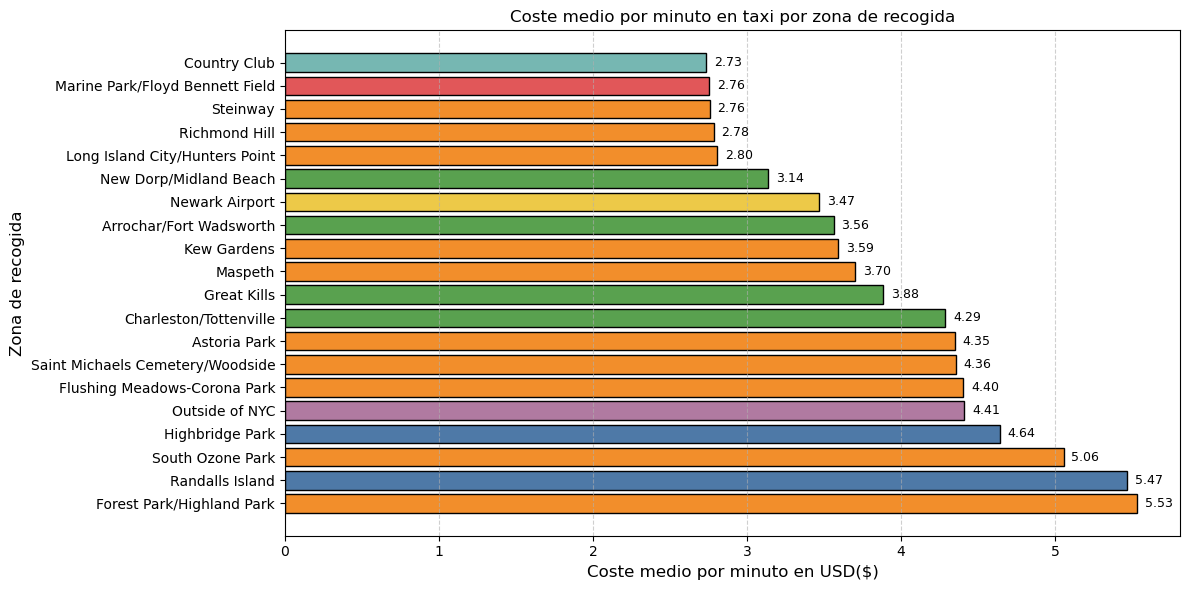

In [12]:
import matplotlib.pyplot as plt

zone_data = avg_cost_per_zone.collect()
top_zones = sorted(zone_data, key=lambda x: x["avg_cost_per_minute"], reverse=True)[:20]

x = [z["Zone"] for z in top_zones]
y = [z["avg_cost_per_minute"] for z in top_zones]
boroughs = [z["Borough"] for z in top_zones]

color_map = {
    "Manhattan": "#4E79A7",
    "Queens": "#F28E2B",
    "Brooklyn": "#E15759",
    "Bronx": "#76B7B2",
    "Staten Island": "#59A14F",
    "EWR": "#EDC948",
    "N/A": "#B07AA1"
}
colors = [color_map.get(b, "#9c9c9c") for b in boroughs]

plt.figure(figsize=(12, 6))
bars = plt.barh(x, y, color=colors, edgecolor='black')

plt.xlabel("Coste medio por minuto en USD($)", fontsize=12)
plt.ylabel("Zona de recogida", fontsize=12)
plt.title("Coste medio por minuto en taxi por zona de recogida")
plt.grid(axis='x', linestyle='--', alpha=0.6)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.05, bar.get_y() + bar.get_height()/2,
             f"{width:.2f}", ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()
